In [1]:
import pathlib

from heliostack import Image, ImageSequence
from heliostack.grid import compute_hull, compute_stack_rates

import torch
import numpy as np

from astropy.io import fits
from astropy.wcs import WCS
from astropy.time import Time
from astropy.coordinates import Angle
from astropy import units as u

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float32

def median_reference_index(epochs):
    return np.where(epochs == np.percentile(epochs, 50, interpolation='nearest'))[0][0]


### Read in all of the images

In [2]:
def ingest_image(image_path, weight_path, device, dtype) -> Image:
    im = fits.open(image_path)
    wt = fits.open(weight_path)

    wcs = WCS(im[1].header)
    epoch = Time(im[1].header['MJD-OBS'], format='mjd', scale='utc')

    image = Image(im[1].data, 
                  wt[1].data, 
                  wcs, 
                  epoch, 
                  device=device,
                  dtype=dtype)
    return image

In [15]:
root = '/nfs/deep/diffim/B1a/20201018/CCD22'
#root = '/Users/kjnapier/Desktop/research/data/jts/B1a/20201018/CCD5/'

image_paths = list(pathlib.Path(root).glob('*.diff.rescale.fits.fz'))[:]
weight_paths = list(pathlib.Path(root).glob('*.diff.weight.fits.fz'))[:]
assert len(image_paths) == len(weight_paths)

# read in the images
images = []
for i, w in zip(image_paths, weight_paths):
    images.append(ingest_image(i, w, device, dtype))
sequence = ImageSequence(images)

### Calculate some metadata

In [16]:
reference_index = median_reference_index(sequence.epochs.numpy())
ra = Angle(sequence.images[reference_index].ra, u.rad)
dec = Angle(sequence.images[reference_index].dec, u.rad)
epoch = Time(sequence.epochs.numpy()[reference_index], format='jd', scale='utc')
duration = (sequence.epochs.max() - sequence.epochs.min()) * u.day

### Calculate the stack rates

In [17]:
hull = compute_hull(ra, dec, epoch, rmin=30, rmax=100, imin=0, imax=90)
ra_rates, dec_rates = compute_stack_rates(hull, 1, duration)

### Stack at each rate, and extract sources

In [18]:
import sep
import pandas as pd

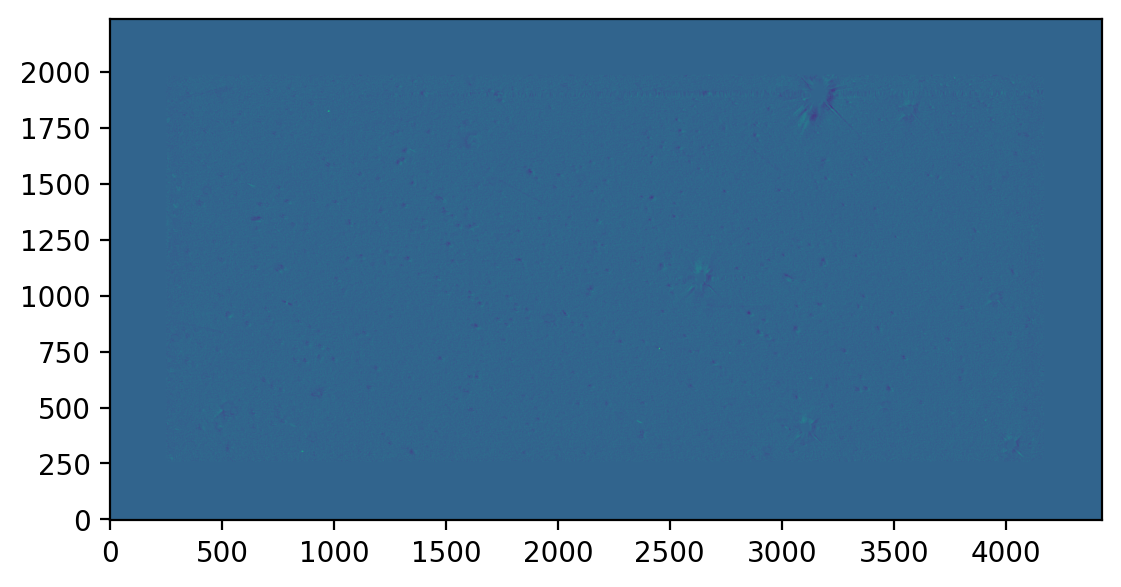

In [19]:
s, wcs = sequence.stack(-2, -1, reference_epoch=reference_index, EDGE_CUT_PIXELS=250, pixel_scale=0.27)
plt.imshow(s.cpu().numpy(), origin='lower')

In [21]:
catalog = []
for ra_rate, dec_rate in zip(ra_rates, dec_rates):
    s, wcs = sequence.stack(ra_rate, dec_rate, reference_epoch=reference_index, EDGE_CUT_PIXELS=250, pixel_scale=0.27)
    s_cpu = np.float32(s.cpu().numpy())
    sources = sep.extract(s_cpu, 2, filter_type='matched')
    if len(sources) == 0:
        continue

    sources = pd.DataFrame(sources)

    # Can put in a neural net layer here

    # Add in the ra, dec, ra_rate, dec_rate
    sources['ra_rate'] = ra_rate
    sources['dec_rate'] = dec_rate
    ras, decs = wcs.all_pix2world(sources['x'], sources['y'], 0)
    sources['ra'] = ras
    sources['dec'] = decs


    # for source in sources.itertuples():
    #     fig, ax = plt.subplots(1, 1, figsize=(2, 2))
    #     ax.imshow(s[int(source.y)-10:int(source.y)+10, int(source.x)-10:int(source.x)+10].cpu().numpy(), origin='lower')

    catalog.append(pd.DataFrame(sources))

catalog = pd.concat(catalog)

In [22]:
catalog

,thresh,npix,tnpix,xmin,xmax,ymin,ymax,x,y,x2,...,peak,xcpeak,ycpeak,xpeak,ypeak,flag,ra_rate,dec_rate,ra,dec
0,2.0,8,7,4055,4058,303,306,4056.230604,304.144240,0.922901,...,3.679090,4056,304,4055,306,0,-3.111234,-2.506049,351.132439,-5.167040
1,2.0,15,13,851,854,309,315,852.575139,312.548899,0.870837,...,3.893109,853,312,853,312,1,-3.111234,-2.506049,351.373691,-5.166394
2,2.0,16,13,3085,3089,448,451,3086.925415,449.706254,1.819373,...,4.673501,3087,450,3088,451,0,-3.111234,-2.506049,351.205433,-5.156128
3,2.0,7,6,2447,2448,770,774,2447.458308,771.796054,0.248262,...,4.214804,2448,771,2448,770,0,-3.111234,-2.506049,351.253586,-5.131970
4,2.0,6,5,289,291,1399,1400,289.974088,1399.475813,0.632730,...,5.027732,290,1399,290,1399,0,-3.111234,-2.506049,351.416030,-5.084865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,2.0,25,22,1353,1363,1645,1650,1357.649889,1647.136411,6.344694,...,3.374385,1357,1648,1357,1646,0,-0.963154,-0.357969,351.336690,-5.065711
16,2.0,31,27,978,991,1819,1824,985.510148,1821.640370,8.228490,...,4.751596,987,1821,987,1821,1,-0.963154,-0.357969,351.364706,-5.052617
17,2.0,29,23,3089,3096,1824,1830,3091.899592,1826.953403,3.166824,...,4.171550,3090,1825,3090,1825,0,-0.963154,-0.357969,351.206114,-5.052237
18,2.0,5,5,1739,1741,1903,1904,1740.204823,1903.381639,0.553349,...,3.305012,1740,1903,1739,1903,0,-0.963154,-0.357969,351.307883,-5.046498
